# Examen
## Diplomado Ciencia de Datos - modulo III  
  
  
  
  
**Profesor: José Gustavo Fuentes Cabrera**  
**Hernández González Ricardo Paramont**  

**DataSet**: credito.csv    
    
**************

## Dependencias

In [1]:
import numpy as np
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold

from varclushi import VarClusHi

from scipy.stats import chisquare
from scipy.stats import kruskal
from statsmodels.stats.multicomp import MultiComparison

from itertools import chain
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

cf.go_offline()
pd.set_option('display.max_columns',None)

***

***
# <p style="text-align: center;">Procesamiento de Datos</p>



***

***

## Lectura de Datos

In [2]:
df = pd.read_csv('credito.csv')
print(f'Tamaño del dataset: {df.shape}')
df.head()

Tamaño del dataset: (2188610, 9)


,id_solicitud,monto_de_credito,tasa_de_interes,ingreso_anual_usd,fecha_de_aprobacion,razon_deuda_vs_ingreso,num_consultas_a_buro_ult_6meses,num_cuentas_abiertas,saldo_promedio_actual
0,XA001115144,6000.0,12.49,42000.0,Oct-2014,16.66,2.0,12.0,1097.0
1,XA002188922,14025.0,15.61,39000.0,Jun-2015,16.86,0.0,10.0,1337.0
2,XA001395696,9000.0,17.99,49000.0,Dec-2016,16.83,1.0,14.0,9623.0
3,XA001095520,35000.0,15.77,140000.0,Jan-2016,12.04,0.0,5.0,9890.0
4,XA001388702,18000.0,12.49,55000.0,May-2014,19.20,0.0,10.0,2953.0


## Definición de variables 

In [3]:
varc = ['monto_de_credito','tasa_de_interes','ingreso_anual_usd','razon_deuda_vs_ingreso',
        'num_consultas_a_buro_ult_6meses','num_cuentas_abiertas','saldo_promedio_actual']
vard = ['fecha_de_aprobacion']

## Completitud

In [4]:
def completitud(df):
    comp=pd.DataFrame(df.isnull().sum())
    comp.reset_index(inplace=True)
    comp=comp.rename(columns={"index":"columna",0:"total"})
    comp["completitud"]=round((1-comp["total"]/df.shape[0])*100, 3)
    comp=comp.sort_values(by="completitud",ascending=True)
    comp.reset_index(drop=True,inplace=True)
    return comp

In [5]:
completitud(df)

,columna,total,completitud
0,id_solicitud,0,100.0
1,monto_de_credito,0,100.0
2,tasa_de_interes,0,100.0
3,ingreso_anual_usd,0,100.0
4,fecha_de_aprobacion,0,100.0
5,razon_deuda_vs_ingreso,0,100.0
6,num_consultas_a_buro_ult_6meses,0,100.0
7,num_cuentas_abiertas,0,100.0
8,saldo_promedio_actual,0,100.0


Aparentemente, no hay registros con valores faltantes.

## Duplicados

In [6]:
df.duplicated().sum()

0

In [7]:
df.duplicated('id_solicitud').sum()

0

No hay duplicados.

## Descomposición de fecha

Se extraerá el mes y año de la solicitud.

In [8]:
df['fecha_de_aprobacion'] = pd.to_datetime(df['fecha_de_aprobacion'])

In [9]:
df['anno'] = df['fecha_de_aprobacion'].dt.year
df['mes'] = df['fecha_de_aprobacion'].dt.month

In [10]:
varc.extend(['anno','mes'])

## Análisis Exploratorio

### Consistencia

In [11]:
df[varc].dtypes

monto_de_credito                   float64
tasa_de_interes                    float64
ingreso_anual_usd                  float64
razon_deuda_vs_ingreso             float64
num_consultas_a_buro_ult_6meses    float64
num_cuentas_abiertas               float64
saldo_promedio_actual              float64
anno                                 int64
mes                                  int64
dtype: object

In [12]:
df[varc].describe()

,monto_de_credito,tasa_de_interes,ingreso_anual_usd,razon_deuda_vs_ingreso,num_consultas_a_buro_ult_6meses,num_cuentas_abiertas,saldo_promedio_actual,anno,mes
count,2.188610e+06,2.188610e+06,2.188610e+06,2.188610e+06,2.188610e+06,2.188610e+06,2.188610e+06,2.188610e+06,2.188610e+06
mean,1.514394e+04,1.310838e+01,7.834685e+04,1.896850e+01,5.643906e-01,1.167431e+01,1.354529e+04,2.016015e+03,6.767244e+00
std,9.212811e+03,4.854360e+00,1.140527e+05,1.433066e+01,8.641439e-01,5.663564e+00,1.646734e+04,1.571605e+00,3.415359e+00
min,1.000000e+03,5.310000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,2.012000e+03,1.000000e+00
25%,8.000000e+03,9.490000e+00,4.650000e+04,1.200000e+01,0.000000e+00,8.000000e+00,3.080000e+03,2.015000e+03,4.000000e+00
50%,1.300000e+04,1.262000e+01,6.500000e+04,1.797000e+01,0.000000e+00,1.100000e+01,7.335000e+03,2.016000e+03,7.000000e+00
75%,2.000000e+04,1.599000e+01,9.400000e+04,2.468000e+01,1.000000e+00,1.500000e+01,1.878100e+04,2.017000e+03,1.000000e+01
max,4.000000e+04,3.099000e+01,1.100000e+08,9.990000e+02,8.000000e+00,1.010000e+02,9.580840e+05,2.018000e+03,1.200000e+01


In [13]:
for v in varc:
    print(v)
    print(f'Mínimo: {df[v].min():,}')
    print(f'Maximo: {df[v].max():,}')
    print('\n')

monto_de_credito
Mínimo: 1,000.0
Maximo: 40,000.0


tasa_de_interes
Mínimo: 5.31
Maximo: 30.99


ingreso_anual_usd
Mínimo: 0.0
Maximo: 110,000,000.0


razon_deuda_vs_ingreso
Mínimo: -1.0
Maximo: 999.0


num_consultas_a_buro_ult_6meses
Mínimo: 0.0
Maximo: 8.0


num_cuentas_abiertas
Mínimo: 1.0
Maximo: 101.0


saldo_promedio_actual
Mínimo: 0.0
Maximo: 958,084.0


anno
Mínimo: 2,012
Maximo: 2,018


mes
Mínimo: 1
Maximo: 12




Se confirma que todas las variables contienen valores dentro de rangos esperados, según el valor min y max.

#### Distribuciones

array([[<AxesSubplot:title={'center':'monto_de_credito'}>,
        <AxesSubplot:title={'center':'tasa_de_interes'}>,
        <AxesSubplot:title={'center':'ingreso_anual_usd'}>],
       [<AxesSubplot:title={'center':'razon_deuda_vs_ingreso'}>,
        <AxesSubplot:title={'center':'num_consultas_a_buro_ult_6meses'}>,
        <AxesSubplot:title={'center':'num_cuentas_abiertas'}>],
       [<AxesSubplot:title={'center':'saldo_promedio_actual'}>,
        <AxesSubplot:title={'center':'anno'}>,
        <AxesSubplot:title={'center':'mes'}>]], dtype=object)

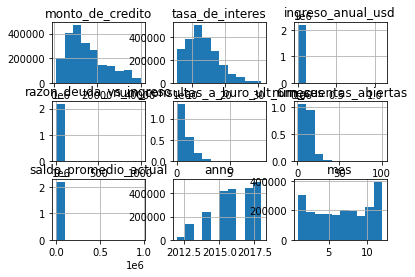

In [14]:
df[varc].hist()

## Extremos

In [15]:
#Buscando extremos segun percentiles 1 y 99
for v,li,ls in df[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    df[f'ex_{v}'] = ((df[v]<li)|(df[v]>ls)).astype(int)
df['ex_'] = df.filter(like='ex_').max(axis=1)

In [16]:
df['ex_'].value_counts(True)
#1 significa que es valor extremo

0    0.914076
1    0.085924
Name: ex_, dtype: float64

8.59% de los registros son valores extremos, procedemos a borrarlos.

In [17]:
#Borrando extremos
df_tot = df
df = df.loc[df['ex_']==0].reset_index(drop=True).drop(df.filter(like='ex_').columns,axis=1)

## Varianza Baja

In [18]:
vt = VarianceThreshold(threshold=0.1)
vt.fit(df[varc])

VarianceThreshold(threshold=0.1)

In [19]:
varianza_peq = [v for v,nu in zip(varc,vt.get_support()) if not nu]
varianza_peq

[]

No hay variables que no pasen el filtro de varianza baja.

## Multicolinealidad

In [20]:
vc = VarClusHi(df=df,feat_list=varc)
vc.varclus()
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1
rs

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,id
0,0,ingreso_anual_usd,0.701359,0.003824,0.299787,1
1,0,monto_de_credito,0.550607,0.017287,0.457299,2
2,0,saldo_promedio_actual,0.462413,0.010225,0.543141,3
3,1,razon_deuda_vs_ingreso,0.645064,0.012789,0.359534,1
4,1,num_cuentas_abiertas,0.645064,0.023655,0.363536,2
5,2,num_consultas_a_buro_ult_6meses,0.517108,0.006983,0.486288,1
6,2,tasa_de_interes,0.466123,0.010283,0.539424,2
7,2,anno,0.285731,0.004587,0.717560,3
8,3,mes,1.000000,0.000810,0.000000,1


Se observa que se puede reducir el número de dimensiones a 3.

In [21]:
var_reduced = sorted(rs.loc[rs['id']==1]['Variable'])

In [22]:
var_reduced

['ingreso_anual_usd',
 'mes',
 'num_consultas_a_buro_ult_6meses',
 'razon_deuda_vs_ingreso']

## Correlación

In [23]:
#Todas la continuas
df[varc].corr().iplot(kind="heatmap",colorscale='spectral')

In [24]:
#Variables que no tienen multicolinealidad
df[var_reduced].corr().iplot(kind="heatmap",colorscale='spectral')

***

***
# <p style="text-align: center;">Previzualización en Espacio Reducido</p>



***

***

## Cambio de espacios 

In [25]:
# Nos quedamos con las variables continuas que no tienen multicolinealidad
X = df[var_reduced].sample(1000, random_state=42).reset_index(drop=True)
df_sample = df.sample(1000, random_state=42).reset_index(drop=True)

### PCA $\mathcal{X}\to\mathcal{X}_p$

In [26]:
sc = StandardScaler()
pca = PCA(n_components=3)
Xp = pd.DataFrame(pca.fit_transform(sc.fit_transform(X)))
print(pca.explained_variance_ratio_.cumsum())

[0.30953091 0.56722003 0.80544251]


### MDS $\mathcal{X}\to\mathcal{X}_m$

In [27]:
sc = MinMaxScaler()
mds = MDS(n_components=3,n_jobs=-1)
Xm = pd.DataFrame(mds.fit_transform(sc.fit_transform(X)))

### t-SNE $\mathcal{X}\to\mathcal{X}_t$

In [28]:
sc = MinMaxScaler()
tsne = TSNE(n_components=3,n_jobs=-1,perplexity=15)
Xt = pd.DataFrame(tsne.fit_transform(sc.fit_transform(X)))

## Visualización preeliminar

### Vectores

In [29]:
Xp.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',color='purple')

In [30]:
Xm.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',color='purple')

In [31]:
Xt.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',color='purple')

### Densidad

<AxesSubplot:xlabel='0', ylabel='1'>

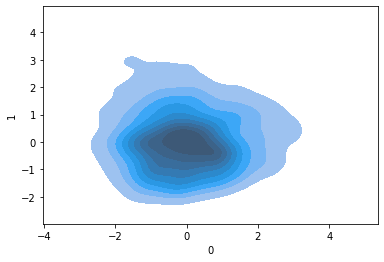

In [32]:
sns.kdeplot(data=Xp,x=0,y=1,fill=True)

<AxesSubplot:xlabel='0', ylabel='1'>

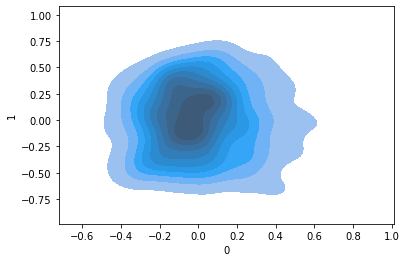

In [33]:
sns.kdeplot(data=Xm,x=0,y=1,fill=True)

<AxesSubplot:xlabel='0', ylabel='1'>

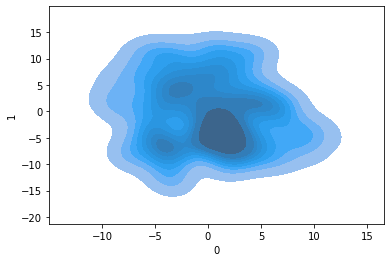

In [34]:
sns.kdeplot(data=Xt,x=0,y=1,fill=True)

***

***
# <p style="text-align: center;">Clustering</p>



***

***

In [35]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X),columns=var_reduced)

## Aglomerativo 

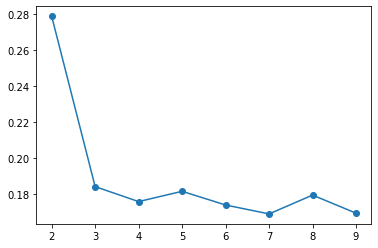

In [36]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              AgglomerativeClustering(n_clusters=k).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [37]:
k = 3
tipo = 'agg'
agg = AgglomerativeClustering(n_clusters=k)
df_sample[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =agg.fit_predict(Xs[var_reduced])

## K-medias

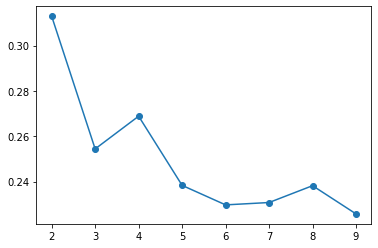

In [38]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              KMeans(n_clusters=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [39]:
k = 4
tipo = 'kme'
kme = KMeans(n_clusters=k,max_iter=1000)
df_sample[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =kme.fit_predict(Xs[var_reduced])

## Modelos Gaussianos Mixtos

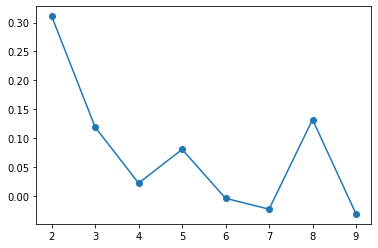

In [40]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              GaussianMixture(n_components=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil'])
plt.plot(sil['k'],sil['sil'],marker='o')

In [41]:
k = 3
tipo = 'gmm'
gmm = GaussianMixture(n_components=k,max_iter=1000)
df_sample[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =gmm.fit_predict(Xs[var_reduced])

## Selección final

In [42]:
varcl = sorted(df_sample.filter(like='cl_'))
for v in varcl:
    Xp[v] = Xp[v].astype(str)
    Xm[v] = Xm[v].astype(str)
    Xt[v] = Xt[v].astype(str)
    df_sample[v] = df_sample[v].astype(str)
    
pd.DataFrame(map(lambda cl:(cl,silhouette_score(Xs,df_sample[cl])),varcl),columns=['cluster','sil']).iplot(kind='bar',categories='cluster')

Se elige el aglomerativo.

## Visualización con cluster

<AxesSubplot:xlabel='0', ylabel='1'>

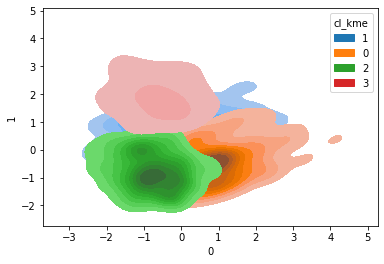

In [43]:
Xp.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories='cl_kme')
sns.kdeplot(data=Xp,x=0,y=1,fill=True,hue='cl_kme')

<AxesSubplot:xlabel='0', ylabel='1'>

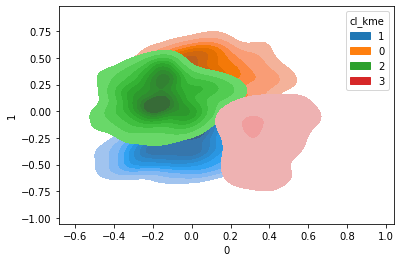

In [44]:
Xm.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories='cl_kme')
sns.kdeplot(data=Xm,x=0,y=1,fill=True,hue='cl_kme')

<AxesSubplot:xlabel='0', ylabel='1'>

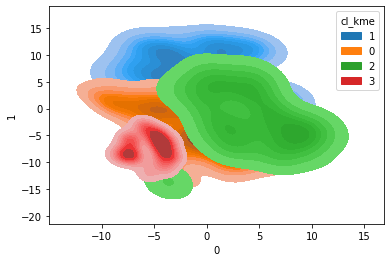

In [45]:
Xt.iplot(kind='scatter3d',x=0,y=1,z=2,mode='markers',categories='cl_kme')
sns.kdeplot(data=Xt,x=0,y=1,fill=True,hue='cl_kme')

## Perfilamiento

### Continuo

ingreso_anual_usd


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-17354.8238,0.001,-25071.4452,-9638.2024,True
0,2,-36638.2299,0.001,-44938.2643,-28338.1955,True
0,3,-17810.9946,0.001,-29972.5079,-5649.4813,True
1,2,-19283.4061,0.001,-27104.6345,-11462.1777,True
1,3,-456.1708,0.9,-12296.08,11383.7383,False
2,3,18827.2352,0.001,6599.0803,31055.3902,True


mes


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-6.2427,0.001,-6.624,-5.8614,True
0,2,-0.5582,0.0027,-0.9683,-0.1481,True
0,3,-4.2696,0.001,-4.8705,-3.6688,True
1,2,5.6845,0.001,5.2981,6.071,True
1,3,1.9731,0.001,1.3881,2.5581,True
2,3,-3.7115,0.001,-4.3156,-3.1073,True


num_consultas_a_buro_ult_6meses


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-0.029,0.9,-0.1393,0.0814,False
0,2,0.0685,0.4481,-0.0502,0.1872,False
0,3,2.1536,0.001,1.9797,2.3274,True
1,2,0.0974,0.1127,-0.0144,0.2093,False
1,3,2.1825,0.001,2.0132,2.3518,True
2,3,2.0851,0.001,1.9102,2.2599,True


razon_deuda_vs_ingreso


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,6.3318,0.001,5.0375,7.6262,True
0,2,14.2484,0.001,12.8562,15.6406,True
0,3,6.6866,0.001,4.6466,8.7265,True
1,2,7.9165,0.001,6.6046,9.2285,True
1,3,0.3547,0.9,-1.6313,2.3407,False
2,3,-7.5618,0.001,-9.613,-5.5107,True


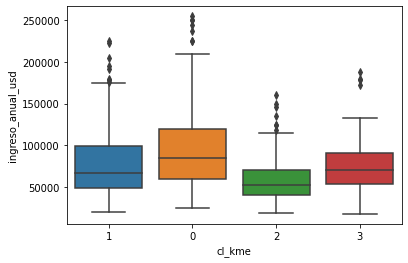

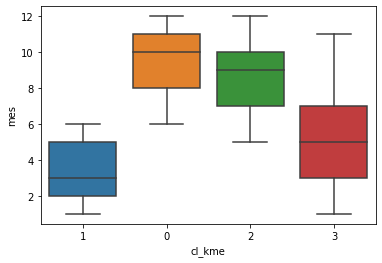

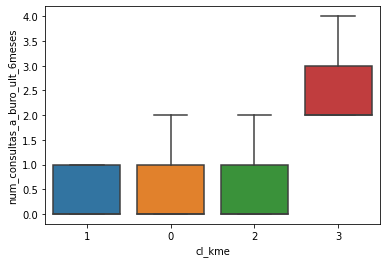

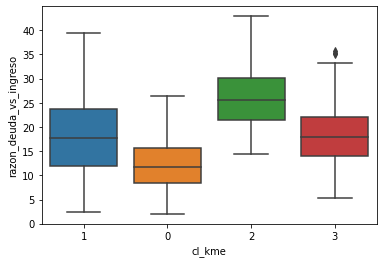

In [46]:
for v in var_reduced:
    print(v)
    display(MultiComparison(df_sample[v],df_sample['cl_kme']).tukeyhsd().summary())
    plt.figure()
    sns.boxplot(data=df_sample,y=v,x='cl_kme')

### Gráfico Radial

In [47]:
Xs['cl_kme'] = df_sample['cl_kme']

In [48]:
aux = Xs[var_reduced+['cl_kme']].groupby('cl_kme').mean()
aux

,ingreso_anual_usd,mes,num_consultas_a_buro_ult_6meses,razon_deuda_vs_ingreso
cl_kme,,,,
0,0.321693,0.768214,0.085106,0.240432
1,0.248620,0.200695,0.077869,0.395321
2,0.167426,0.717472,0.102230,0.588974
3,0.246699,0.380066,0.623494,0.403998


In [49]:
fig = go.Figure()

for i,row in aux.iterrows():
    fig.add_trace(go.Scatterpolar(r=row.values,
                                  theta=var_reduced,
                                  fill='toself',
                                  name=f'cluster {i}'))
fig.show()

## Arquetipos

In [50]:
display(df_sample[var_reduced+['cl_kme']].groupby('cl_kme').mean())
display(df_sample[var_reduced].mean().to_frame().T)

,ingreso_anual_usd,mes,num_consultas_a_buro_ult_6meses,razon_deuda_vs_ingreso
cl_kme,,,,
0,93902.018723,9.450355,0.340426,11.828865
1,76547.194945,3.207650,0.311475,18.160710
2,57263.788848,8.892193,0.408922,26.077249
3,76091.024096,5.180723,2.493976,18.515422


,ingreso_anual_usd,mes,num_consultas_a_buro_ult_6meses,razon_deuda_vs_ingreso
0,76216.15683,6.661,0.527,18.53412


* Cluster 0: ingreso anual medio, dentro del primer cuatrimestre del año, bajas consultas a buro y razón deuda/ingreso media.
* Cluster 1: Ingreso anual alto, dentro del último cuatrimestre del año, bajas conultas a buro y baja razón deuda/ingreso.
* Cluster 2: Ingreso anual medio, en el segundo cuatrimestre del año, alto número de consultas a buro y razón deuda/ingreso media.
* Cluster 3: Ingreso anual bajo, en el tercer trimestre del año, bajas consultas a buro y muy alta razón de deuda/ingreso.

## Estabilidad en el tiempo

In [51]:
df_sample['cl'] = kme.predict(sc.transform(df_sample[var_reduced])).astype(str)

In [52]:
df_sample['cl'].value_counts(1)

1    0.366
0    0.282
2    0.269
3    0.083
Name: cl, dtype: float64

In [53]:
piv = df_sample.pivot_table(index='fecha_de_aprobacion',columns='cl',values='id_solicitud',aggfunc='count',fill_value=0)
piv['t'] = piv.sum(axis=1)
for v in range(4):
    piv[str(v)]/=piv['t']
piv.drop('t',axis=1,inplace=True)
piv

cl,0,1,2,3
fecha_de_aprobacion,,,,
2012-09-01,0.000000,0.0,1.000000,0.000000
2012-10-01,0.428571,0.0,0.571429,0.000000
2012-11-01,0.666667,0.0,0.000000,0.333333
2012-12-01,1.000000,0.0,0.000000,0.000000
2013-01-01,0.000000,0.5,0.000000,0.500000
...,...,...,...,...
2018-08-01,0.475000,0.0,0.375000,0.150000
2018-09-01,0.375000,0.0,0.500000,0.125000
2018-10-01,0.476190,0.0,0.523810,0.000000


In [54]:
piv.iplot(kind='bar',barmode='stack')

Se reagrupa por año, descontando el 2012 por no tener completo dicho periodo.

In [55]:
piv = df_sample.pivot_table(index='fecha_de_aprobacion',columns='cl',values='id_solicitud',aggfunc='count',fill_value=0)
piv = piv.resample('AS').sum()
piv['t'] = piv.sum(axis=1)
for v in range(4):
    piv[str(v)]/=piv['t']
piv.drop('t',axis=1,inplace=True)
piv.drop(pd.to_datetime('2012-01-01'),inplace=True)
piv

cl,0,1,2,3
fecha_de_aprobacion,,,,
2013-01-01,0.406250,0.234375,0.250000,0.109375
2014-01-01,0.247619,0.314286,0.314286,0.123810
2015-01-01,0.235294,0.363636,0.288770,0.112299
2016-01-01,0.242268,0.463918,0.226804,0.067010
2017-01-01,0.276699,0.378641,0.291262,0.053398
2018-01-01,0.324675,0.354978,0.246753,0.073593


In [56]:
piv.iplot(kind='bar',barmode='stack')

In [57]:
benchmark = piv.loc['2017-01-01'].to_frame().T
benchmark.index = ['benchmark']
benchmark

cl,0,1,2,3
benchmark,0.276699,0.378641,0.291262,0.053398


In [58]:
for v in range(1):
    piv[f'psi_{v}'] = (piv[f'{v}']-benchmark[f'{v}'][0])*np.log(piv[f'{v}']/benchmark[f'{v}'][0])

In [59]:
piv['psi'] = piv.filter(like='psi_').sum(axis=1)

In [60]:
piv[['psi']].assign(insignificante=0.1).assign(cambio_menor=0.25).iplot(kind='line')

## Guardadon resultados

In [65]:
X_total = df_tot[['id_solicitud']+var_reduced]

In [66]:
X_total['cluster'] = kme.fit_predict(X_total[var_reduced])

In [67]:
X_total[['id_solicitud','cluster']].to_csv('HERNANDEZ_GONZALEZ_RICARDO_PARAMONT.csv',index=False,header=False)

In [68]:
X_total[['id_solicitud','cluster']]

,id_solicitud,cluster
0,XA001115144,2
1,XA002188922,2
2,XA001395696,2
3,XA001095520,0
4,XA001388702,2
...,...,...
2188605,XA001458461,2
2188606,XA001360646,2
2188607,XA001138999,2
2188608,XA000114571,2
